# Index Construction

Can use BSBI, SPIMI, and distributed indexing to make index construction more scalable.

## Hardware Limitations and Bottlenecks
`Seek time` - time a mechanical hand takes to move to a random location in the disk

`Transfer time` - time to transfer a data block

- Access to data in memory is *much* faster than acces to data on disk. 
- No data is transferred during disk seeks, hence transferring *large chunks* of data from disk to memory is faster than transferring many small chunks. 
- Disk I/O is block based



`s` - Average seek time, is on average *8 ms*

`b` - Transfer time per byte, is on average *0.006 μs*

- Dataset used is [Reteurs RCV1](https://archive.ics.uci.edu/ml/datasets/Reuters+RCV1+RCV2+Multilingual,+Multiview+Text+Categorization+Test+collection)
- It is a newswire collection from 1995 and 1996
- 800,000 documents; 100,000,000 non-positional postings; avg. bytes per token: 4.5; avg. bytes per term: 7.5
- Average no. of bytes per token is lower because of stop word removal. Many tokens may actually be stop words, and the removal of them will lead to the average size per token being lower.

## Blocked Sort-Based Indexing
- Idea is to sort with fewer disk seeks
- 8-byte (4+4) records (termID, docID)
- We now sort 8-byte records by termID (termID used instead of the term to increase speed)
- Basic idea: accumulate postings for each *block*, sort, then write to disk
- Then merge the blocks into one long sorted order

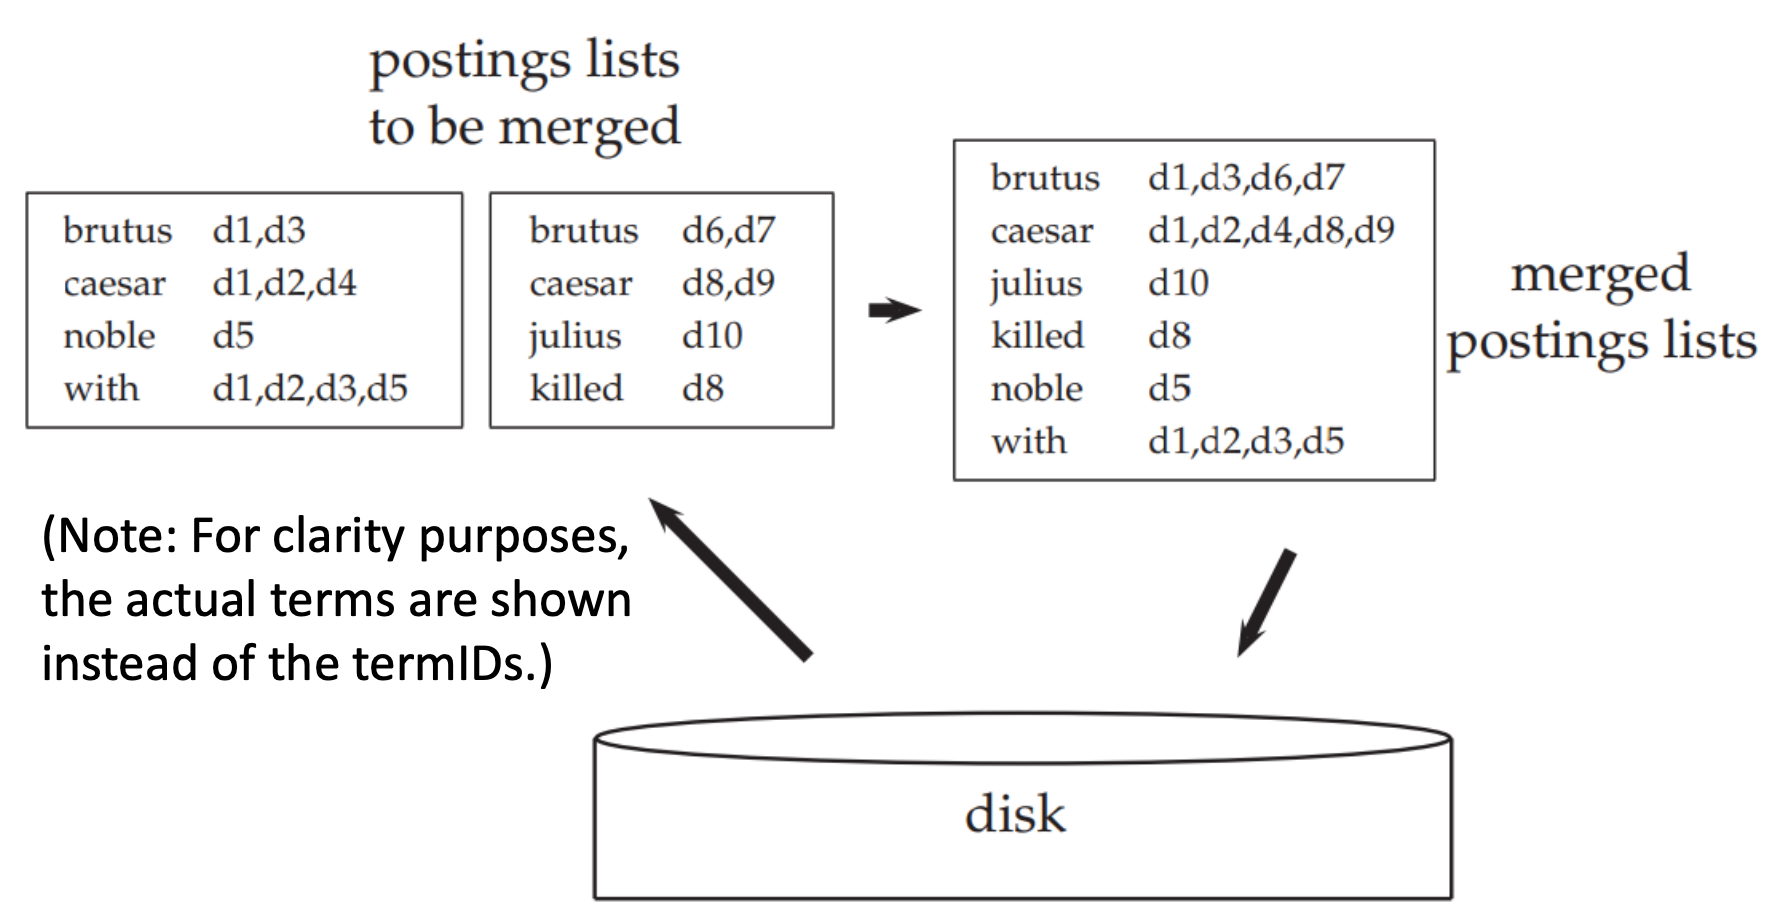

### Sorting example
In order to sort 10 blocks of 10 million records:

1. Accumulate entries for a block, sort within and write to this disk:
2. Quicksort takes *N* in *N* expected steps (in our case 10 million in 10 million steps)
3. 10 times this estimate - 10 sorted *runs* of 10 million records each on disk

### Merging the blocks
First approach: binary merge with a merge tree. During each layer, read into memory runs in blocks of 10 million, merge, then write back. 

Second approach (n-way merge):
1. Reading from all blocks simultaneously
2. Read decent-sized chunks of each block into memory, merge, then write out to decent sized output chunk. Efficiency isn't lost by disk seeks

#### Limitations:
1. Limited according to the number of file descriptors we have. eg. if we have 256 file descriptors we can only do 255 merges at once (save 1 for the main file).
2. Can we really keep the entire dictionary in memory?
3. If the blocks are originally unsorted, time complexity could be dominated by the hard disk seeks

In [1]:
# Sorting 2 blocks - 2 way merge
# In a tuple, the first element is the term ID and the second is the docID and frequency
block1 = [(1, (1,2)), (1, (2,1)), (1, (3, 1)), (2, (3,1)), (3, (3,1)), (4, (1,1))]
block2 = [(2, (5,1)), (1, (4,1)), (1, (5,1)), (3, (5,1)), (2, (4,1)), (3, (4,1)), (4, (4,1))]

# Sort phase
block1.sort()
block2.sort()

# They are now sorted within their blocks
print (block1)
print (block2)


# Merging
p1 = 0
p2 = 0
merge = []
while (p1 < len(block1) and p2 < len(block2)):
    if (block1[p1] < block2[p2]):
        merge.append(block1[p1])
        p1 += 1
    else:
        merge.append(block2[p2])
        p2 += 1
while (p1 < len(block1)):
    merge.append(block1[p1])
    p1 += 1
    
while (p2 < len(block2)):
    merge.append(block2[p2])
    p2 += 1

print("=============================")
i = 0
while (i < len(merge)):
    curr_term = merge[i][0]
    combined_list = []
    d = i
    while (d < len(merge) and merge[d][0] == curr_term):
        combined_list.append(merge[d][1])
        d += 1
    i = d
    print (curr_term,":", combined_list)


[(1, (1, 2)), (1, (2, 1)), (1, (3, 1)), (2, (3, 1)), (3, (3, 1)), (4, (1, 1))]
[(1, (4, 1)), (1, (5, 1)), (2, (4, 1)), (2, (5, 1)), (3, (4, 1)), (3, (5, 1)), (4, (4, 1))]
1 : [(1, 2), (2, 1), (3, 1), (4, 1), (5, 1)]
2 : [(3, 1), (4, 1), (5, 1)]
3 : [(3, 1), (4, 1), (5, 1)]
4 : [(1, 1), (4, 1)]


## Single-Pass in-memory indexing
- Idea #1: Generate separate dictionaries for each block - no need to maintain term-termID mapping across blocks. 
- Idea #2: Build the postings list in a single pass (Not at the end like BSBI, where a sort phase is needed)
- These separate indices can then be merged into one big index

In [2]:
# SPIMI - simulating one step
FREE_MEMORY = 5
# Mess of unordered term and docID pair
token_stream = [("hello", (1,2)), ("hello", (2,1)), ("hello", (3, 1)), 
                ("kun", (3,1)), ("tze", (3,1)), ("guang", (1,1)), 
                ("kun", (5,1)), ("hello", (4,1)), ("hello", (5,1)), 
                ("tze", (5,1)), ("kun", (4,1)), ("tze", (4,1)), 
                ("guang", (4,1))]
i = 0
dictionary = {}
while (i < FREE_MEMORY and i < len(token_stream)):
    curr_token = token_stream[i]
    i += 1
    if (curr_token[0] not in dictionary):
        dictionary[curr_token[0]] = [curr_token[1]]
    else:
        dictionary[curr_token[0]].append(curr_token[1])
        
    # If postings list is full, we can also choose to double it here

# Sort everything in this block
for term in dictionary:
    dictionary[term].sort()
    
# Write out to file - this completes one block, now we go back to while loop and repeat
for term in dictionary:
    print (term, ":", dictionary[term])
# Notice we don't get all the postings from the token_stream, that's because we ran out of memory!!

hello : [(1, 2), (2, 1), (3, 1)]
kun : [(3, 1)]
tze : [(3, 1)]


## Differences between SPIMI and BSBI
1. SPIMI adds a posting directly to its postings list instead of first collecting all termID-docID pairs and then sorting them (as we did in BSBI), each postings list is dynamic (i.e., its size is adjusted as it grows) and it is immediately available to collect postings. 
- This has two advantages:
(i) It is faster because there is no sorting required
(ii) It saves memory because we keep track of the term a postings list belongs to, so the termIDs of postings need not be stored

2. BSBI is not suitable for very large collections as it needs an extra data structure which will not fit into memory. SPIMI uses terms instead of term IDs, writes each block's dictionary to disk, and then starts a new dictionary for the next block.

3. Compression techniques can be used with SPIMI to make the index construction process even faster. 

4. BSBI time complexity is NLogN - while SPIMI is N (in extreme cases it will be NLogN) 

## Distributed Indexing
1. Maintain a *master* machine directing the indexing job (although master nodes can fail too)
2. Break up indexing into sets of (parallel) tasks
3. Master machine assigns each task to an idle *worker* machine from a pool

Let us assume there are two sets of parallel tasks - *parsers* and *inverters*
- Break the document collection into *splits*
- Each *split* is a subset of documents

Parsers
- Master assigns split to an idle parser machine
- Parser reads one document at a time and emits **(term, doc)** pairs
- Parser writes pairs into j partitions
- Each partition is for a range of terms' first letters
- Will now be passed for index conversion

Inverters
- Inverter collects all **(term, doc)** pairs for one term-partition
- Sorts and writes to postings list


The Data flow of such a distributed indexing mechanism is summarised in the image below

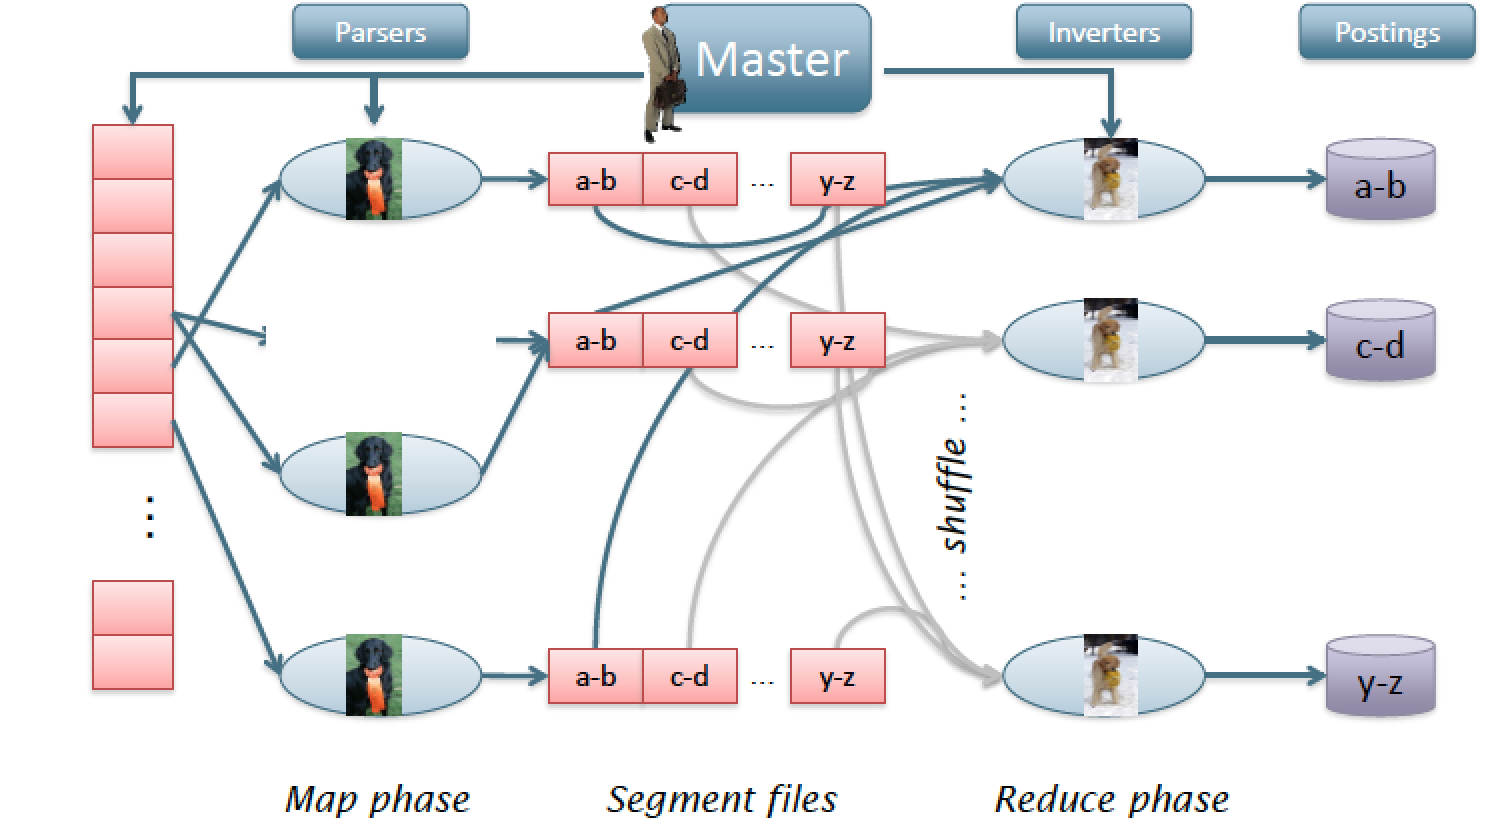

In [3]:
from IPython.display import Image
Image(filename="Data_Flow.png", width=800, height=400)

## MapReduce
MapReduce is a robust and simple framework for distributed computing without having to write code for the distribution.

- Index construction was one phase
- Next phase: transforming a term-partitioned index into a document-partitioned index
- *Term partitioned*: one machine handles a subrange of terms
- *Document partitioned*: one machine handles a subrange of documents

Most search engines use a document partitioned index for better load balancing

Map and Reduce Functions:
- map: input -> list(k, v)
- reduce: (k, list(v)) -> output

Instantitation of the schema for index construction
- map: web collection -> list(termID, docID)
- reduce: (<termID1, list(docID)>, <termID2, list(docID)>,...) -> (postings list 1, postings list 2)

In [4]:
"""MAPPER"""
import sys

# input comes from STDIN (standard input)
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()
    # split the line into words
    words = line.split()
    # increase counters
    for word in words:
        # write the results to STDOUT (standard output);
        # what we output here will be the input for the
        # Reduce step, i.e. the input for reducer.py
        # tab-delimited; the trivial word count is 1
        print ("%s\t%s" % (word, 1))

In [5]:
"""REDUCER"""

from operator import itemgetter
import sys

current_word = None
current_count = 0
word = None

# input comes from STDIN
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper.py
    word, count = line.split('\t', 1)

    # convert count (currently a string) to int
    try:
        count = int(count)
    except ValueError:
        # count was not a number, so silently
        # ignore/discard this line
        continue

    # this IF-switch only works because Hadoop sorts map output
    # by key (here: word) before it is passed to the reducer
    if current_word == word:
        current_count += count
    else:
        if current_word:
            # write result to STDOUT
            print ("%s\t%s" % (current_word, current_count))
        current_count = count
        current_word = word

# do not forget to output the last word if needed!
if current_word == word:
    print ("%s\t%s" % (current_word, current_count))

None	0


## Dynamic Indexing
- In the real world, documents are added and deleted all the time

### Approach #1
- Maintain a "big" main index
- New docs go into the **"small" aux memory**
- Search across both, merge results
- For deletions, have an **invalidation bit-vector** for deleted docs
- Periodically, re-index into one main index
- Assuming *T total number of postings and *n* as size of auxiliary index, we touch each posting up to *floor(T/n)* times

### Issues with approach #1:
- Frequent merging is inefficient
- Poor performance during merge
- Solution is to use logarithmic merge (maintain a series of indexes, each twice as large as the previous one):

1. Keep smallest in memory
2. Larger ones on disk
3. If smallest gets too big, write to disk or merge with those on disk

Now with logarithmic merge: Each posting is merged O(log T) times, so complexity is O(T log T)
Before for auxiliary and main index: index construction time is a + 2a + 3a + 4a + ... + na = a n(n+1)/2 = O(T^2)

Logarithmic merging is faster, but query processing now requires merging of O(log T) indices, whereas it is O(1) if you just have a main and auxiliary index

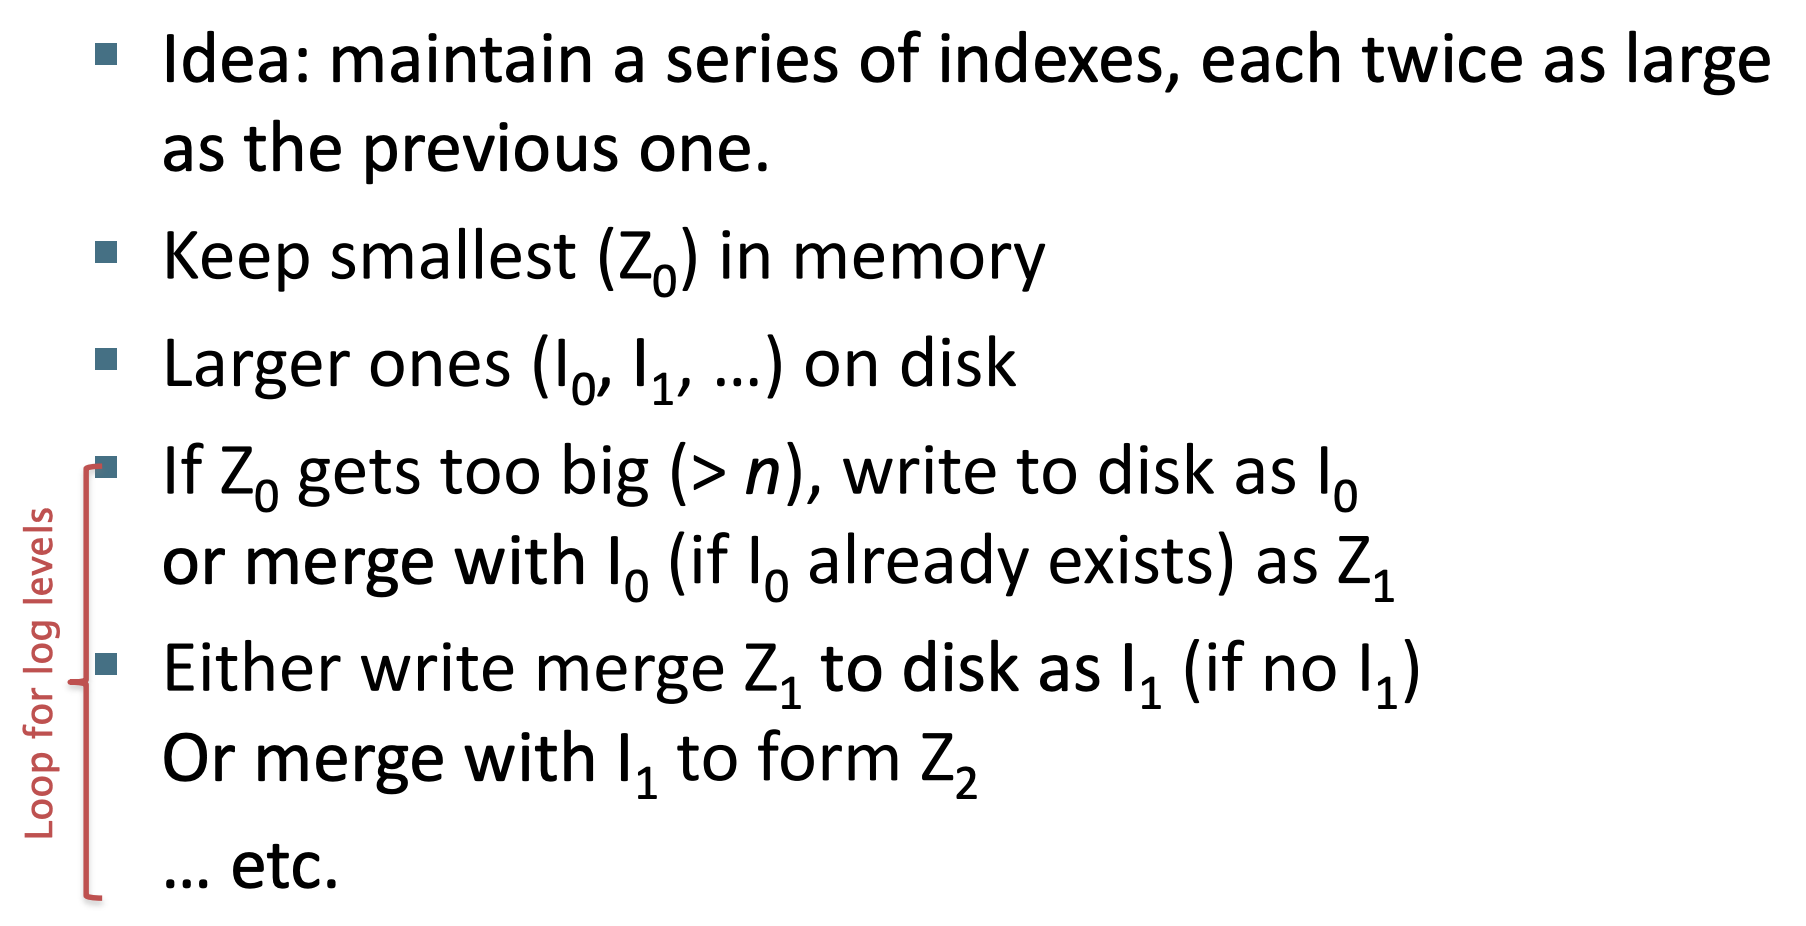


### Other indexing problems
1. Positional indexes problems when sorting
2. Building character n-gram indices requires pointers to all dictionary terms containing it - the "postings"